<a href="https://colab.research.google.com/github/kelvinfoo123/Time-Series-Analysis/blob/main/LSTM_Stock_Price_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Import and Prepare Data set**

In [12]:
import pandas as pd 

df = pd.read_csv("MSFT.csv")
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,1986-03-13,0.088542,0.101563,0.088542,0.097222,0.060809,1031788800
1,1986-03-14,0.097222,0.102431,0.097222,0.100694,0.062980,308160000
2,1986-03-17,0.100694,0.103299,0.100694,0.102431,0.064067,133171200
3,1986-03-18,0.102431,0.103299,0.098958,0.099826,0.062437,67766400
4,1986-03-19,0.099826,0.100694,0.097222,0.098090,0.061351,47894400
...,...,...,...,...,...,...,...
9258,2022-12-05,252.009995,253.820007,248.059998,250.199997,250.199997,23435300
9259,2022-12-06,250.820007,251.860001,243.779999,245.119995,245.119995,22463700
9260,2022-12-07,244.830002,246.160004,242.210007,244.369995,244.369995,20481500
9261,2022-12-08,244.839996,248.740005,243.059998,247.399994,247.399994,22611800


In [13]:
# For simplicity, we only use the date and closing values 

df = df[["Date", "Close"]]
df

,Date,Close
0,1986-03-13,0.097222
1,1986-03-14,0.100694
2,1986-03-17,0.102431
3,1986-03-18,0.099826
4,1986-03-19,0.098090
...,...,...
9258,2022-12-05,250.199997
9259,2022-12-06,245.119995
9260,2022-12-07,244.369995
9261,2022-12-08,247.399994


In [14]:
# Date is currently a string object and not a datetime object 

import datetime 

def str_to_datetime(s): 
  split = s.split('-')
  year, month, day = int(split[0]), int(split[1]), int(split[2])
  return datetime.datetime(year = year, month = month, day = day)

df['Date'] = df['Date'].apply(str_to_datetime)
df['Date']

<ipython-input-14-717017e809a6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Date'] = df['Date'].apply(str_to_datetime)


0      1986-03-13
1      1986-03-14
2      1986-03-17
3      1986-03-18
4      1986-03-19
          ...    
9258   2022-12-05
9259   2022-12-06
9260   2022-12-07
9261   2022-12-08
9262   2022-12-09
Name: Date, Length: 9263, dtype: datetime64[ns]

In [15]:
# Replace index with dates instead of integers 

df.index = df.pop('Date')
df

,Close
Date,
1986-03-13,0.097222
1986-03-14,0.100694
1986-03-17,0.102431
1986-03-18,0.099826
1986-03-19,0.098090
...,...
2022-12-05,250.199997
2022-12-06,245.119995
2022-12-07,244.369995


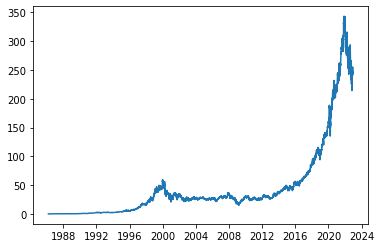

In [16]:
import matplotlib.pyplot as plt 

plt.plot(df.index, df['Close'])

## **Turn the problem into a supervised learning problem for LSTM**

In [22]:
import numpy as np

def df_to_windowed_df(dataframe, first_date_str, last_date_str, n=3):
  first_date = str_to_datetime(first_date_str)
  last_date  = str_to_datetime(last_date_str)

  target_date = first_date
  
  dates = []
  X, Y = [], []

  last_time = False
  while True:
    df_subset = dataframe.loc[:target_date].tail(n+1)
    
    if len(df_subset) != n+1:
      print(f'Error: Window of size {n} is too large for date {target_date}')
      return

    values = df_subset['Close'].to_numpy()
    x, y = values[:-1], values[-1]

    dates.append(target_date)
    X.append(x)
    Y.append(y)

    next_week = dataframe.loc[target_date:target_date+datetime.timedelta(days=7)]
    next_datetime_str = str(next_week.head(2).tail(1).index.values[0])
    next_date_str = next_datetime_str.split('T')[0]
    year_month_day = next_date_str.split('-')
    year, month, day = year_month_day
    next_date = datetime.datetime(day=int(day), month=int(month), year=int(year))
    
    if last_time:
      break
    
    target_date = next_date

    if target_date == last_date:
      last_time = True
    
  ret_df = pd.DataFrame({})
  ret_df['Target Date'] = dates
  
  X = np.array(X)
  for i in range(0, n):
    X[:, i]
    ret_df[f'Target-{n-i}'] = X[:, i]
  
  ret_df['Target'] = Y

  return ret_df

In [45]:
windowed_df = df_to_windowed_df(df, '2021-12-09', '2022-12-09', n = 3)
windowed_df

,Target Date,Target-3,Target-2,Target-1,Target
0,2021-12-09,326.190002,334.920013,334.970001,333.100006
1,2021-12-10,334.920013,334.970001,333.100006,342.540009
2,2021-12-13,334.970001,333.100006,342.540009,339.399994
3,2021-12-14,333.100006,342.540009,339.399994,328.339996
4,2021-12-15,342.540009,339.399994,328.339996,334.649994
...,...,...,...,...,...
248,2022-12-05,255.139999,254.690002,255.020004,250.199997
249,2022-12-06,254.690002,255.020004,250.199997,245.119995
250,2022-12-07,255.020004,250.199997,245.119995,244.369995
251,2022-12-08,250.199997,245.119995,244.369995,247.399994




*   Target is the output, which is also the closing price of the target date. 
*   Target - 3 represents closing price for the date that is 3 day behind the target date. 

*   Target - 3, target - 2 and target - 1 are inputs to the supervised learning problem while target is the output to the supervised learning problem. 





In [46]:
# Convert to numpy array to be used for LSTM 

def windowed_df_to_date_X_y(windowed_dataframe): 
  df_as_np = windowed_dataframe.to_numpy()

  dates = df_as_np[:,0]

  middle_matrix = df_as_np[:, 1:-1]
  X = middle_matrix.reshape((len(dates), middle_matrix.shape[1], 1)) # Last output is 1 because we only depend on closing price. 

  Y = df_as_np[:,-1]

  return dates, X.astype(np.float32), Y.astype(np.float32)

dates, X, y = windowed_df_to_date_X_y(windowed_df)

## **Splitting data**

In [47]:
q_80 = int(len(dates) * 0.8)
q_90 = int(len(dates) * 0.9)

dates_train, X_train, y_train = dates[:q_80], X[:q_80], y[:q_80]

dates_val, X_val, y_val = dates[q_80:q_90], X[q_80:q_90], y[q_80:q_90]
dates_test, X_test, y_test = dates[q_90:], X[q_90:], y[q_90:]

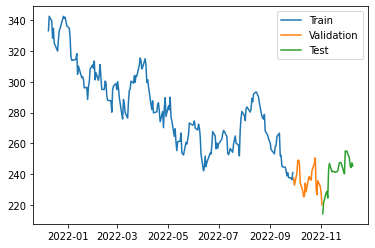

In [48]:
plt.plot(dates_train, y_train)
plt.plot(dates_val, y_val)
plt.plot(dates_test, y_test)

plt.legend(['Train', 'Validation', 'Test'])

## **Building LSTM**

In [49]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers

In [50]:
model = Sequential([layers.Input((3,1)), 
            layers.LSTM(64), 
            layers.Dense(32, activation = 'relu'), 
            layers.Dense(32, activation = 'relu'), 
            layers.Dense(1)])

In [51]:
model.compile(loss = 'mse', optimizer = Adam(learning_rate = 0.001), metrics = ['mean_absolute_error'])

model.fit(X_train, y_train, validation_data = (X_val, y_val), epochs = 100)

Epoch 1/100
7/7 [==============================] - 3s 94ms/step - loss: 80620.1016 - mean_absolute_error: 282.7897 - val_loss: 55205.9844 - val_mean_absolute_error: 234.8200
Epoch 2/100
7/7 [==============================] - 0s 8ms/step - loss: 80262.0625 - mean_absolute_error: 282.1554 - val_loss: 54914.2852 - val_mean_absolute_error: 234.1980
Epoch 3/100
7/7 [==============================] - 0s 8ms/step - loss: 79871.0078 - mean_absolute_error: 281.4631 - val_loss: 54525.9805 - val_mean_absolute_error: 233.3676
Epoch 4/100
7/7 [==============================] - 0s 8ms/step - loss: 79378.3359 - mean_absolute_error: 280.5849 - val_loss: 54089.8945 - val_mean_absolute_error: 232.4314
Epoch 5/100
7/7 [==============================] - 0s 9ms/step - loss: 78811.1719 - mean_absolute_error: 279.5718 - val_loss: 53518.4609 - val_mean_absolute_error: 231.1987
Epoch 6/100
7/7 [==============================] - 0s 10ms/step - loss: 78027.8438 - mean_absolute_error: 278.1685 - val_loss: 52678.7

7/7 [==============================] - 0s 3ms/step


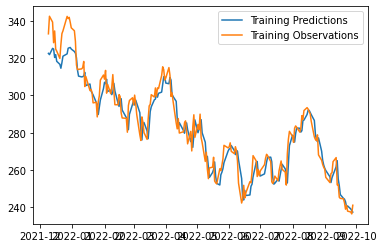

In [52]:
train_predictions = model.predict(X_train).flatten()

plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.legend(['Training Predictions', 'Training Observations'])

1/1 [==============================] - 0s 26ms/step


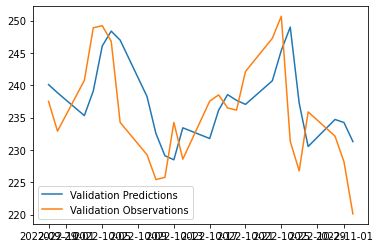

In [53]:
val_predictions = model.predict(X_val).flatten()

plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.legend(['Validation Predictions', 'Validation Observations'])

1/1 [==============================] - 0s 21ms/step


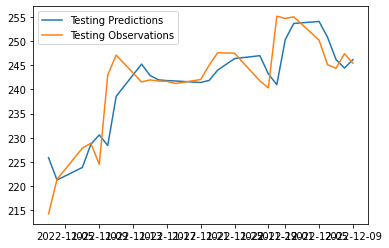

In [54]:
test_predictions = model.predict(X_test).flatten()

plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.legend(['Testing Predictions', 'Testing Observations'])

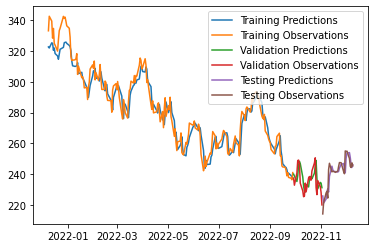

In [55]:
plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.legend(['Training Predictions', 
            'Training Observations',
            'Validation Predictions', 
            'Validation Observations',
            'Testing Predictions', 
            'Testing Observations'])